In [1]:
import logging
import os
import random
import pprint
import yaml
import numpy as np
import torch
from torch import nn
from source.domain.experiment import (
    get_data,
    evaluate,
    train,
    predict,
    make_loader,
    make_model,
    make_optimizer,
)

# save weights and biases api key to .env file in project directory
assert os.getenv('WANDB_API_KEY')
assert torch.cuda.is_available()

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)  # noqa: NPY002
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

logging.config.fileConfig(
    os.path.join(os.getcwd(), '/code/source/config/logging.conf'),
    # defaults={'logfilename': os.path.join(os.getcwd(), 'tests/test_files/log.log')},
    disable_existing_loggers=False,
)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config_file = '/code/source/entrypoints/run_fc_1.yaml'
config_file = '/code/source/entrypoints/run_cnn_2.yaml'

In [3]:
with open(config_file) as f:
    config = yaml.safe_load(f)

pprint.pprint(config)

{'architecture': 'CNN',
 'batch_size': 64,
 'epochs': 40,
 'kernel_sizes': [3, 5],
 'learning_rate': 0.01,
 'notes': 'changed to out_channels and kernel_sizes',
 'num_reduce_learning_rate': 3,
 'optimizer': 'adam',
 'out_channels': [16, 32],
 'project': 'pytorch-demo-v2',
 'tags': ['pytorch', 'demo']}


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging.info(f"Device: {device}")

2024-01-02 01:31:25 - INFO     | Device: cuda:0


---

In [5]:
config.layers if 'layers' in config else None

In [6]:
x_train, x_val, x_test, y_train, y_val, y_test = get_data(architecture=config['architecture'])
train_loader = make_loader(x_train, y_train, batch_size=config['batch_size'])
validation_loader = make_loader(x_val, y_val, batch_size=config['batch_size'])
model = make_model(
    architecture=config['architecture'],
    input_size=28*28,
    layers=config['layers'] if 'layers' in config else None,
    out_channels=config['out_channels'] if 'out_channels' in config else None,
    kernel_sizes=config['kernel_sizes'] if 'kernel_sizes' in config else None,
    device=device,
)
criterion = nn.CrossEntropyLoss()
optimizer_creator = make_optimizer(optimizer=config['optimizer'], model=model)

2024-01-02 01:31:31 - INFO     | Training set  : X-torch.Size([56000, 1, 28, 28]), y-torch.Size([56000])
2024-01-02 01:31:31 - INFO     | Validation set: X-torch.Size([7000, 1, 28, 28]), y-torch.Size([7000])
2024-01-02 01:31:31 - INFO     | Test set      : X-torch.Size([7000, 1, 28, 28]), y-torch.Size([7000])


ConvNet2L(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [18]:
print(model.layer1[0].weight.shape)
print(model.layer2[0].weight.shape)

torch.Size([16, 1, 3, 3])
torch.Size([32, 16, 5, 5])


In [7]:
train(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    criterion=criterion,
    optimizer_creator=optimizer_creator,
    epochs=1, #,config['epochs'],
    learning_rate=config['learning_rate'],
    device=device,
    num_reduce_learning_rate=config['num_reduce_learning_rate'],
    log_wandb=False,
)

2024-01-02 01:31:31 - INFO     | Training on cuda:0; epochs: 1; learning rate: 0.01
  0%|          | 0/1 [00:00<?, ?it/s]2024-01-02 01:31:31 - INFO     | Epoch: 0 | Learning Rate: 0.010
2024-01-02 01:31:32 - INFO     | Epoch: 0 | Learning Rate: 0.010000: Avg Training/Validation Loss after 64 examples: 2.285 | 5.077
2024-01-02 01:31:32 - INFO     | Epoch: 0 | Learning Rate: 0.010000: Avg Training/Validation Loss after 1,920 examples: 2.195 | 1.111
2024-01-02 01:31:33 - INFO     | Epoch: 0 | Learning Rate: 0.010000: Avg Training/Validation Loss after 3,776 examples: 0.668 | 0.410
2024-01-02 01:31:33 - INFO     | Epoch: 0 | Learning Rate: 0.010000: Avg Training/Validation Loss after 5,632 examples: 0.308 | 0.291
2024-01-02 01:31:33 - INFO     | Epoch: 0 | Learning Rate: 0.010000: Avg Training/Validation Loss after 7,488 examples: 0.270 | 0.249
2024-01-02 01:31:34 - INFO     | Epoch: 0 | Learning Rate: 0.010000: Avg Training/Validation Loss after 9,344 examples: 0.244 | 0.231
2024-01-02 01

In [8]:
predictions = predict(model=model, x=x_test, device=device)
print(predictions[0:10])
predictions = predictions.cpu().numpy()
print(predictions[0:10])

tensor([5, 7, 5, 1, 1, 8, 2, 3, 3, 3], device='cuda:0')
[5 7 5 1 1 8 2 3 3 3]


In [9]:
predictions = predict(model=model, x=x_test, device=device, probs=True)
predictions = predictions.cpu().numpy().round(2)
print(predictions[0:10])

[[0.   0.   0.   0.   0.   0.98 0.   0.   0.01 0.  ]
 [0.   0.   0.   0.03 0.   0.   0.   0.96 0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.75 0.   0.02 0.   0.   0.   0.   0.23 0.  ]
 [0.   0.88 0.01 0.   0.   0.   0.   0.04 0.07 0.  ]
 [0.19 0.   0.   0.   0.   0.   0.   0.   0.8  0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.86 0.   0.01 0.   0.   0.12 0.01]
 [0.   0.   0.   0.97 0.   0.02 0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]]


2024-01-02 01:31:43 - INFO     | Final Average Loss on training set: 0.146
2024-01-02 01:31:43 - INFO     | Final Average Loss on validation set: 0.157
2024-01-02 01:31:43 - INFO     | Final Average Loss on test set: 0.160
2024-01-02 01:31:45 - INFO     | Weighted Precision: 0.953, Recall: 0.950, F1: 0.950
2024-01-02 01:31:45 - INFO     | Accuracy: 0.950


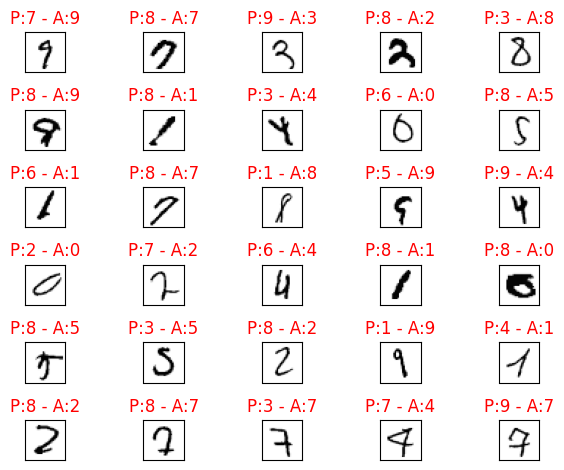

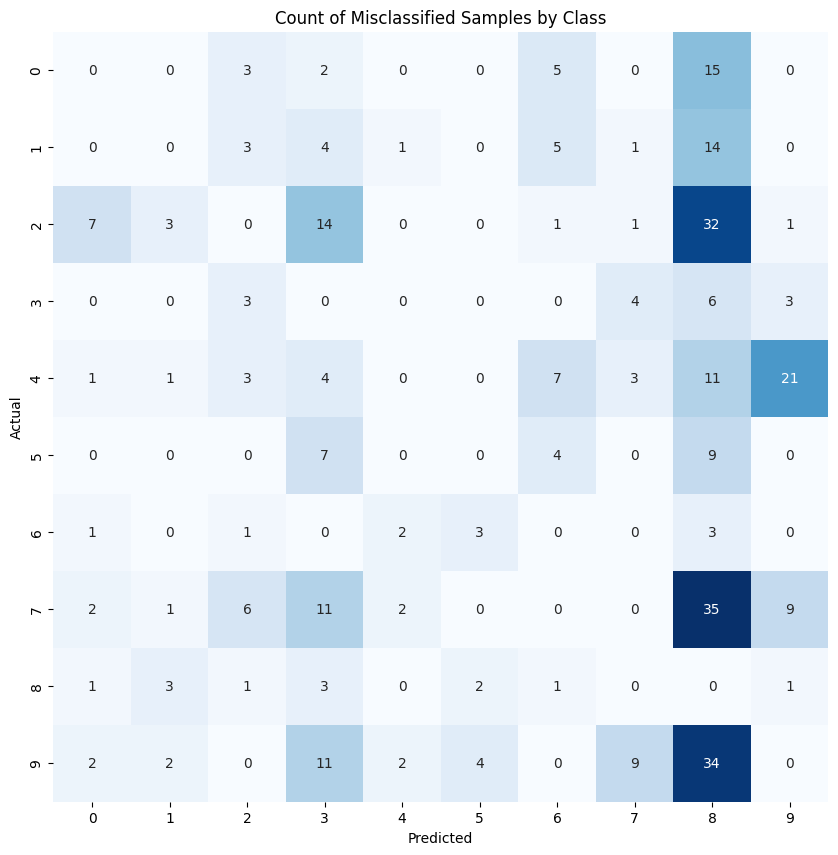

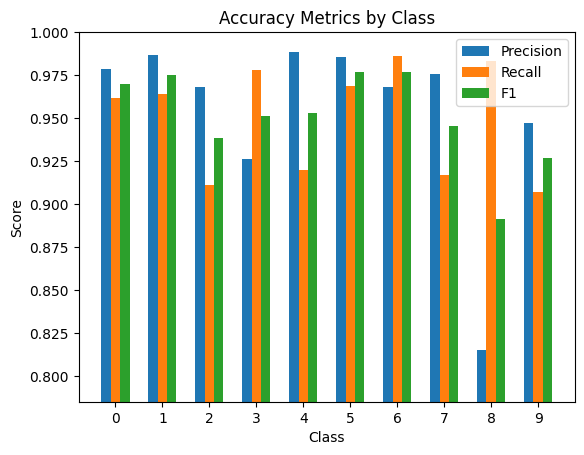

In [10]:
evaluate(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    x_test=x_test,
    y_test=y_test,
    criterion=criterion,
    device=device,
    log_wandb=False,
)